In [1]:
from pandas_datareader import data  # You will need to run "pip install pandas_datareader"
import holidays   # You will need to run "pip install holidays"
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Useful resources:

https://readthedocs.org/projects/pandas-datareader/downloads/pdf/latest/

https://www.investopedia.com/terms/c/consumerpriceindex.asp

https://www.investopedia.com/insights/understanding-consumer-confidence-index/

https://fred.stlouisfed.org/series

In [2]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

def previous_business_day(specific_date):
    previous_day = specific_date  
    while previous_day.weekday() in holidays.WEEKEND or previous_day in HOLIDAYS_US:
        previous_day -= ONE_DAY
    return previous_day

def next_business_day(specific_date):
    next_day = specific_date  
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

In [3]:
def get_historical_data(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    try:
        panel_data = data.DataReader(share, source, start_date, end_date)
    except: 
        panel_data = pd.DataFrame()
    return panel_data

In [4]:
def compute_average_annual_return(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    panel_data = get_historical_data(share, start_date, end_date, source)
    if panel_data.empty:
        return None, None, None, None, None
    
    adj_close = panel_data['Adj Close']
    
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    
    while start_date.strftime('%Y-%m-%d') not in adj_close.index: 
        start_date = next_business_day(start_date)
    
    while end_date.strftime('%Y-%m-%d') not in adj_close.index: 
        end_date = previous_business_day(end_date)
    
    delta = end_date - start_date
    years = delta.days / 365
    
    start_price = adj_close.loc[start_date.strftime('%Y-%m-%d')]
    end_price = adj_close.loc[end_date.strftime('%Y-%m-%d')]
    
    return_value = (end_price/start_price)**(1/years) - 1
    return round(return_value, 4), start_date, end_date, delta, years

In [5]:
def compute_daily_return_std_per_year(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    panel_data = get_historical_data(share, start_date, end_date, source)
    if panel_data.empty:
        return None
    
    last_day_price = None
    daily_returns = [] 
    for index, row in panel_data.iterrows():
        if last_day_price:
            daily_returns.append(row['Adj Close']/last_day_price - 1)
        last_day_price = row['Adj Close']
    return round(np.std(daily_returns)*np.sqrt(252), 4)

In [6]:
def compute_sharpe(share, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    avg, _, _, _, _ = compute_average_annual_return(share, start_date, end_date, source)
    std = compute_daily_return_std_per_year(share, start_date, end_date, source)
    if not avg or not std:
        return 
    return round(avg/std, 4)

In [7]:
SP_500 = pd.read_excel('SP_500.xlsx', index_col=0)
SP_500_symbol_list = SP_500.index.to_list()[:-2]

In [8]:
iTickers = {}
iTickers["SPY"] = "SPDR S&P 500 ETF Trust"
iTickers["VOO"] = "Vanguard S&P 500 ETF"
iTickers["VTI"] = "Vanguard Total Stock Market ETF"
iTickers["BRK-B"] = "Berkshire Hathaway Inc."
iTickers["AAPL"] = "Apple Inc."
iTickers["BAC"] = "Bank of America"
iTickers["MSFT"] = "Microsoft"
iTickers["IVV"] = "iShares Core S&P 500 ETF"
iTickers["NFLX"] = "Netflix"

In [ ]:
for symb in SP_500_symbol_list:  
    print("---------------\n", symb)
    sharpe_ratio = compute_sharpe(symb)
    print(SP_500.loc[symb]['Name'], sharpe_ratio)

SPDR S&P 500 ETF Trust
SPDR S&P 500 ETF Trust 2.4649
Vanguard S&P 500 ETF
Vanguard S&P 500 ETF 2.5269
Vanguard Total Stock Market ETF
Vanguard Total Stock Market ETF 2.4393
Berkshire Hathaway Inc.
Berkshire Hathaway Inc. 0.7833
Apple Inc.
Apple Inc. 3.42
Bank of America
Bank of America 1.9287
Microsoft
Microsoft 2.9596
iShares Core S&P 500 ETF
iShares Core S&P 500 ETF 2.5012
Netflix
Netflix 0.6069


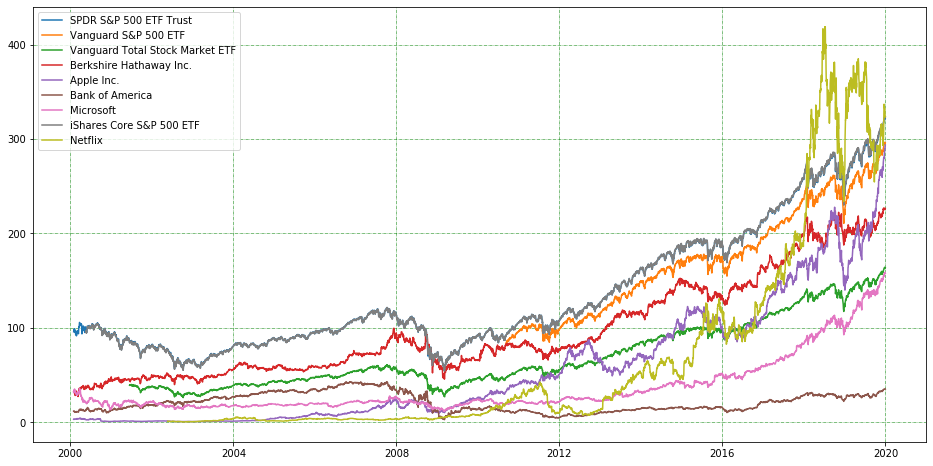

In [9]:
plt.figure(figsize=(16,8))
start_date='2000-01-31' 
for symb in iTickers:
    print(iTickers[symb])
    daa = get_historical_data(symb, start_date=start_date)
    sharpe_ratio = compute_sharpe(symb)
    #print(SP_500.loc[symb]['Name'], sharpe_ratio)
    print(iTickers[symb], sharpe_ratio)
    plt.plot(daa['Adj Close'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.legend([iTickers[sym] for sym in iTickers])
plt.savefig('well-known-tickers.png')

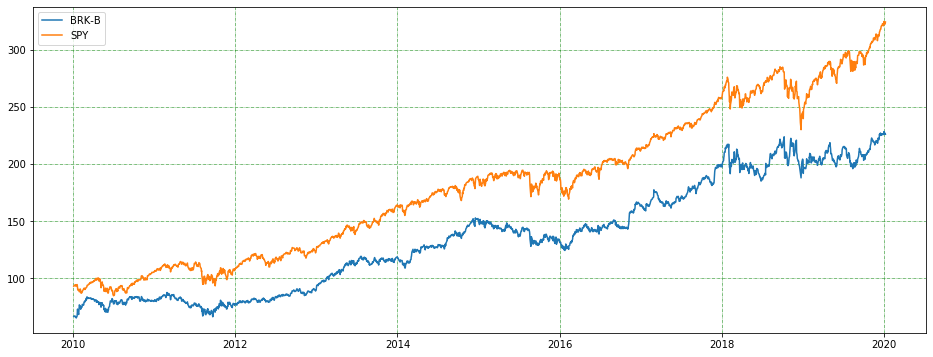

In [10]:
plt.figure(figsize=(16,6))
start_date='2010-01-02' 
end_date='2020-01-07' 
for symb in ['BRK-B','SPY']:
    daa = get_historical_data(symb, start_date=start_date, end_date=end_date)
    plt.plot(daa['Adj Close'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.legend(['BRK-B','SPY'])
plt.savefig('BRK_vs_SPY.png')

In [11]:
def plot_stock_price(stock, start_date='2019-01-02', end_date='2019-12-31', source='yahoo'):
    plt.figure(figsize=(16,6))
    daa = get_historical_data(stock, start_date=start_date, end_date=end_date, source=source)
    sharpe_ratio = compute_sharpe(stock)
    plt.plot(daa['Adj Close'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend([stock])
    plt.savefig('{}_{}_{}.png'.format(stock, start_date, end_date))

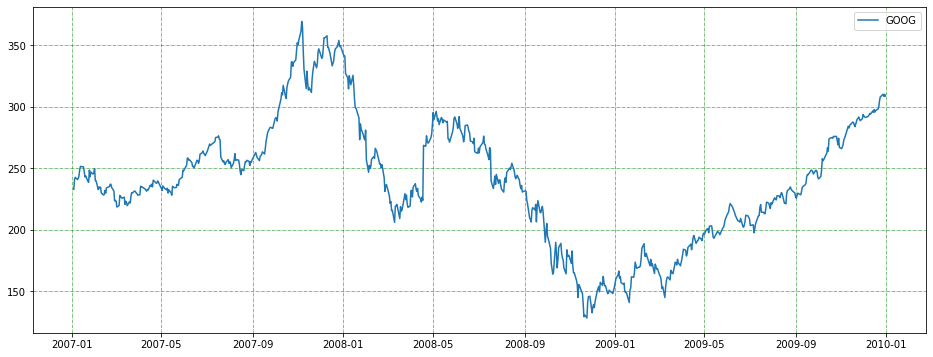

In [12]:
plot_stock_price('GOOG', start_date='2007-01-02', end_date='2010-01-02')

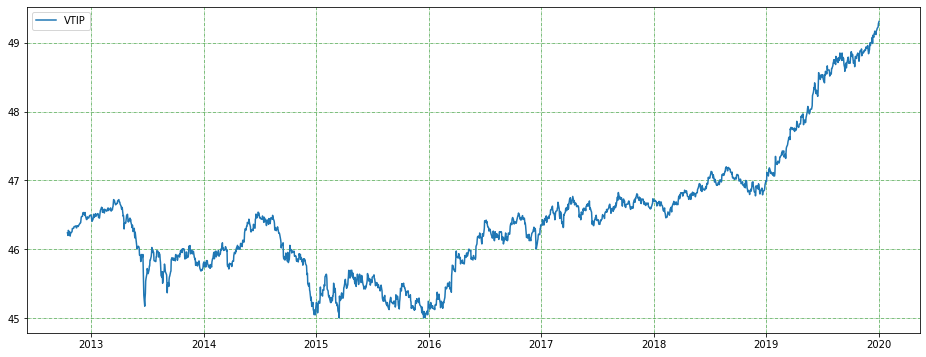

In [13]:
plot_stock_price('VTIP', start_date='1990-01-01', end_date='2020-01-01')

Vanguard 500 Index Fund Admiral Shares

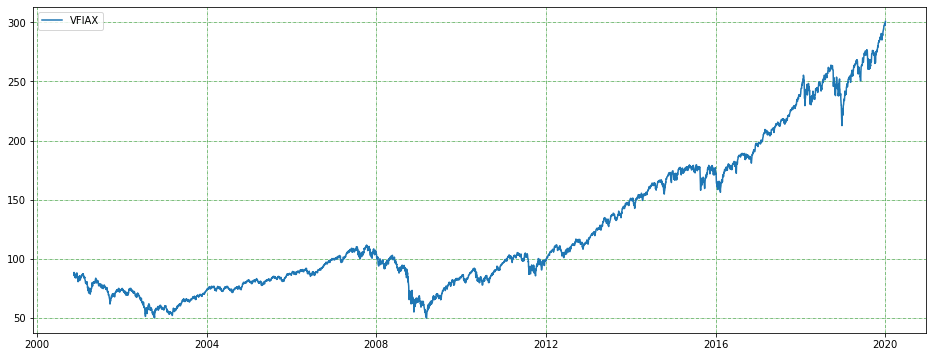

In [14]:
plot_stock_price('VFIAX', start_date='1990-01-01', end_date='2020-01-01')

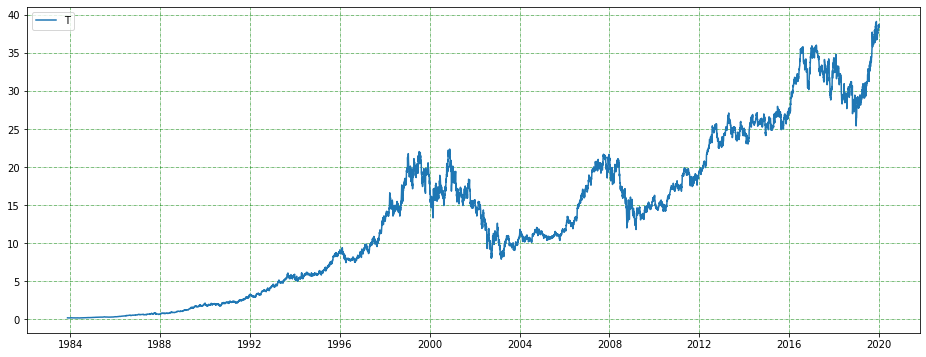

In [15]:
plot_stock_price('T', start_date='1980-01-01', end_date='2020-01-01')

iShares 20+ Year Treasury Bond ETF (TLT)

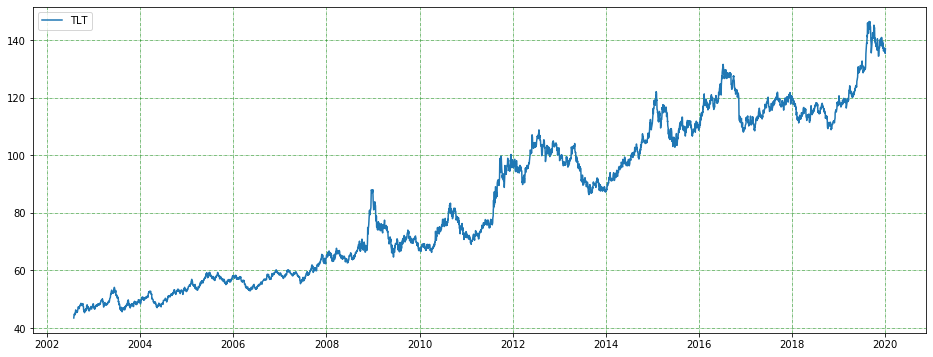

In [16]:
plot_stock_price('TLT', start_date='1900-01-01', end_date='2020-01-01')

13 Week treasury bill

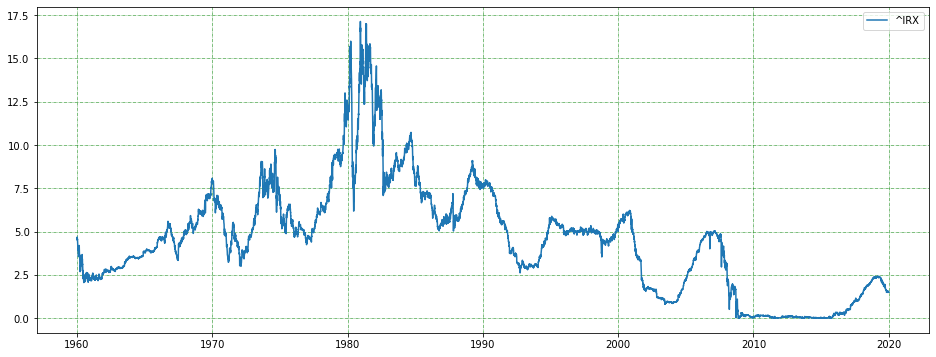

In [18]:
plot_stock_price('^IRX', start_date='1900-01-01', end_date='2020-01-01')

30 Year Treasury bill

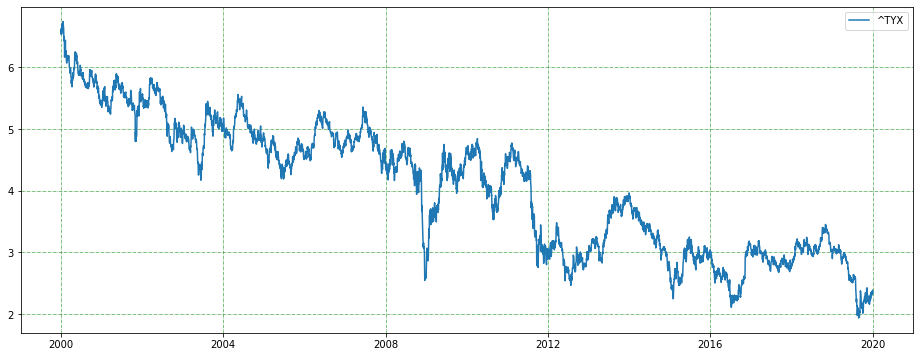

In [21]:
plot_stock_price('^TYX', start_date='2000-01-01', end_date='2020-01-01')

Vanguard Target Retirement 2045 Fund Investor Shares

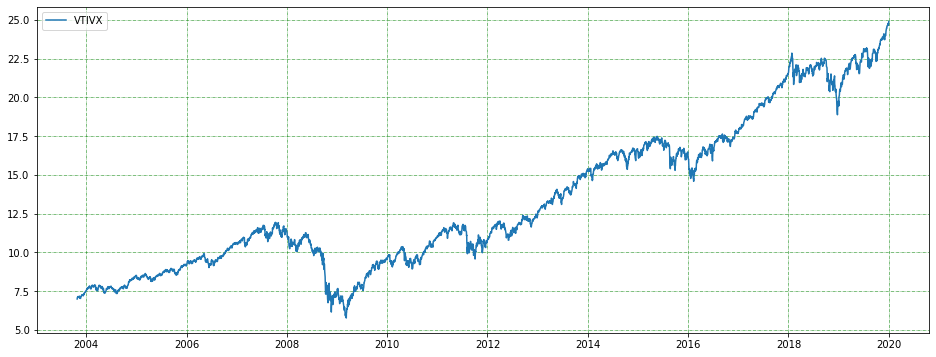

In [22]:
plot_stock_price('VTIVX', start_date='2000-01-01', end_date='2020-01-01')

In [23]:
def compute_avg_annual_return_between_2_periods(shares, start_date='2000-01-02', end_date='2019-12-31', source='yahoo'):
    shares_data = get_historical_data(shares, start_date=start_date, end_date=end_date, source=source)
    adj_close = shares_data['Adj Close']
    
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    
    while start_date.strftime('%Y-%m-%d') not in adj_close.index: 
        start_date = next_business_day(start_date)
    
    while end_date.strftime('%Y-%m-%d') not in adj_close.index: 
        end_date = previous_business_day(end_date)
    
    start_prices = adj_close.loc[start_date.strftime('%Y-%m-%d')]
    end_prices = adj_close.loc[end_date.strftime('%Y-%m-%d')]
    #print(end_prices, start_prices)
    return (end_prices/start_prices)**(1/(end_date.year - start_date.year)) - 1

In [24]:
SP500_rate_of_return_all = compute_avg_annual_return_between_2_periods(SP_500_symbol_list)
SP500_rate_of_return = {x:round(SP500_rate_of_return_all.loc[x],2) for x in SP500_rate_of_return_all.index \
                        if not pd.isnull(SP500_rate_of_return_all.loc[x])}

/Users/mkarimzadehkis/anaconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BF.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/mkarimzadehkis/anaconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BHGE', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/mkarimzadehkis/anaconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/mkarimzadehkis/anaconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'HCP', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/mkarimzadehkis/anaconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'SYMC', replacing with NaN.
  warnings.warn(msg.for

In [25]:
SP500_rate_of_return_clean = {k: v for k, v in sorted(SP500_rate_of_return.items(), key=lambda item: item[1])}
SP500_rate_of_return_clean

{'AIG': -0.15,
 'ETFC': -0.09,
 'AKAM': -0.07,
 'C': -0.07,
 'ARNC': -0.04,
 'GE': -0.04,
 'JNPR': -0.04,
 'F': -0.03,
 'GPS': -0.03,
 'IPG': -0.03,
 'AES': -0.02,
 'XRX': -0.02,
 'CTL': -0.01,
 'WY': -0.01,
 'DISH': 0.0,
 'GLW': -0.0,
 'M': 0.0,
 'MSI': 0.0,
 'CSCO': 0.01,
 'FITB': 0.01,
 'MS': 0.01,
 'NWL': 0.01,
 'VRSN': 0.01,
 'ZION': 0.01,
 'DXC': 0.02,
 'HBAN': 0.02,
 'IVZ': 0.02,
 'JCI': 0.02,
 'KSS': 0.02,
 'MU': 0.02,
 'QCOM': 0.02,
 'UNM': 0.02,
 'A': 0.03,
 'CCL': 0.03,
 'DD': 0.03,
 'HOG': 0.03,
 'HPQ': 0.03,
 'IBM': 0.03,
 'IP': 0.03,
 'KEY': 0.03,
 'MOS': 0.03,
 'NTAP': 0.03,
 'RF': 0.03,
 'TXT': 0.03,
 'APA': 0.04,
 'BK': 0.04,
 'BMY': 0.04,
 'CTXS': 0.04,
 'DVN': 0.04,
 'FCX': 0.04,
 'HAL': 0.04,
 'HIG': 0.04,
 'INCY': 0.04,
 'INTC': 0.04,
 'LB': 0.04,
 'MXIM': 0.04,
 'MYL': 0.04,
 'ORCL': 0.04,
 'PWR': 0.04,
 'SEE': 0.04,
 'SLB': 0.04,
 'T': 0.04,
 'TAP': 0.04,
 'WMB': 0.04,
 'AMAT': 0.05,
 'CPB': 0.05,
 'FFIV': 0.05,
 'KSU': 0.05,
 'LNC': 0.05,
 'NEM': 0.05,
 'OMC': 0

In [26]:
compute_avg_annual_return_between_2_periods('BRK-B')

0.10278063728967202

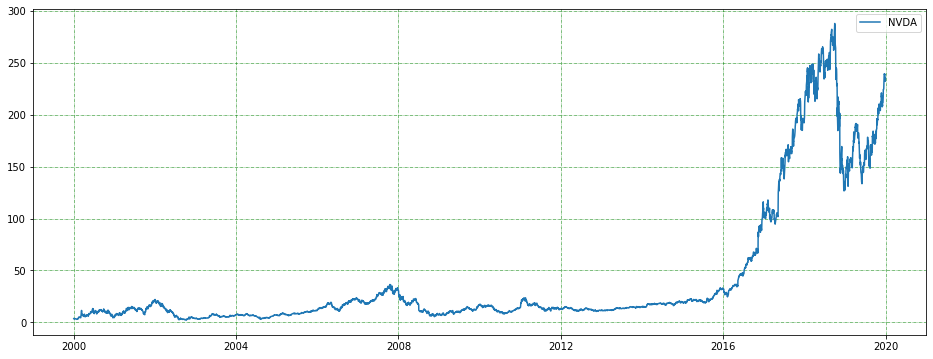

In [27]:
plot_stock_price('NVDA', start_date='2000-01-02', end_date='2019-12-31')

# Overall economic indicators

In [28]:
def plot_us_gdp(start_date = '1900-01-01', end_date = '2020-01-01'):
    plt.figure(figsize=(16,6))
    gdp_data = get_historical_data('GDP', start_date = start_date, end_date = end_date, source = 'fred')
    plt.plot(gdp_data)
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend(['US GDP'])
    plt.savefig('us_gdp.png')

In [29]:
def plot_us_inflation(start_date='1940-01-01', end_date='2020-01-01', index ='CPILFESL'):
    CPI  = get_historical_data(index, start_date = start_date, end_date = end_date, source = 'fred')
    CPI['CPI_Diff_monthly'] = CPI[index].diff()
    CPI['CPI_Diff_yearly'] = CPI[index].diff(12)
    CPI['CPI_monthly_inflation_rate'] = (CPI['CPI_Diff_monthly']/CPI[index])*100
    CPI['CPI_yearly_inflation_rate_pp'] = (CPI['CPI_Diff_yearly']/CPI[index])*100
    plt.figure(figsize=(16,6))
    plt.plot(CPI['CPI_monthly_inflation_rate'])
    plt.plot(CPI['CPI_yearly_inflation_rate_pp'])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend(['US monthly inflation rate', 'US yearly point to point inflation rate'])
    plt.savefig('us_inflation_data_{}.png'.format(index))
    return CPI

In [30]:
def plot_index(index, start_date = '2010-01-02', end_date = '2020-01-02', source = 'fred'):
    indx  = get_historical_data(index, start_date, end_date, source)
    plt.figure(figsize=(16,6))
    plt.plot(indx)
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    index_meaning = {'DGS30': '30-Year Treasury Constant Maturity Rate',
                     'DGS20': '20-Year Treasury Constant Maturity Rate',
                     'DGS10': '10-Year Treasury Constant Maturity Rate', 
                     'DGS7': '7-Year Treasury Constant Maturity Rate',
                     'DGS5': '5-Year Treasury Constant Maturity Rate',
                     'DGS3': '3-Year Treasury Constant Maturity Rate',
                     'DGS2': '2-Year Treasury Constant Maturity Rate',
                     'DGS1': '1-Year Treasury Constant Maturity Rate',
                     'DGS6MO': '6-Month Treasury Constant Maturity Rate',
                     'DGS3MO': '3-Month Treasury Constant Maturity Rate',
                     'DGS1MO': '1-Month Treasury Constant Maturity Rate', 
                     'FEDFUNDS': 'US Effective Federal Funds Rate',
                     'LIBOR': '3-Month London Interbank Offered Rate',
                     'NIKKEI225': 'Nikkei Stock Average, Nikkei 225',
                     'UNRATE': 'US Civilian Unemployment Rate',
                     'GFDEGDQ188S': 'Federal Debt: Total Public Debt as Percent of Gross Domestic Product',
                     'GDPC1': 'Real Gross Domestic Product percent change',
                     'A191RL1Q225SBEA': 'Real Gross Domestic Product dollars',
                     'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items',
                     'IRLTLT01JPM156N': 'Long-Term Government Bond Yields: 10-year: Japan'
                    }
    plt.legend([index_meaning[index]])
    plt.savefig('index_{}_{}_{}.png'.format(index, start_date, end_date))

In [31]:
def plot_yield_curve(specific_date):
    next_date = next_business_day(datetime.datetime.strptime(specific_date, '%Y-%m-%d'))
    specific_date = next_date.strftime('%Y-%m-%d')
    syms = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
    yc = data.DataReader(syms, 'fred', specific_date, specific_date)
    names = dict(zip(syms, ['1m', '3m', '6m', '1yr', '2yr', '3yr', '5yr', '7yr', '10yr', '20yr', '30yr']))
    yc = yc.rename(columns=names)
    plt.figure(figsize=(16,6))
    #plt.plot([1, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360], yc.loc[specific_date])
    plt.plot(yc.loc[specific_date])
    plt.grid(color='g', linestyle='-.', linewidth=0.5)
    plt.legend(['US Yield Curve on {}'.format(specific_date)])
    plt.savefig('yield_curve_{}.png'.format(specific_date))
    return yc.loc[specific_date]

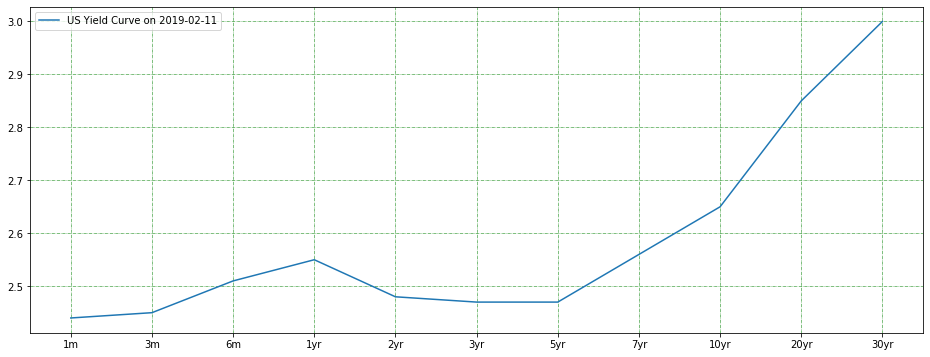

In [32]:
yields = plot_yield_curve('2019-02-11')

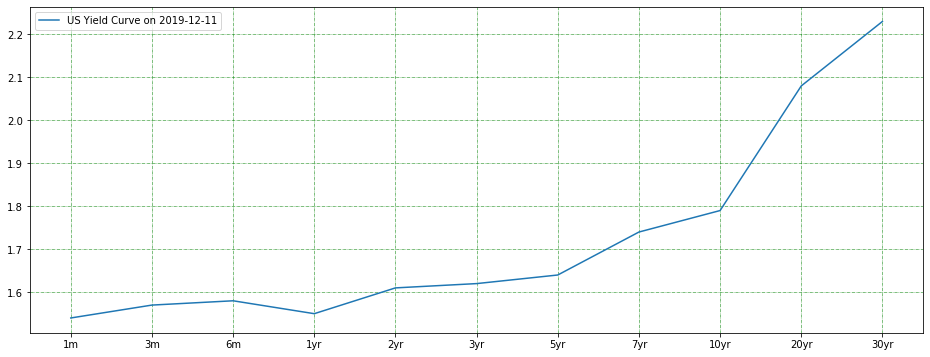

In [33]:
yields = plot_yield_curve('2019-12-11')

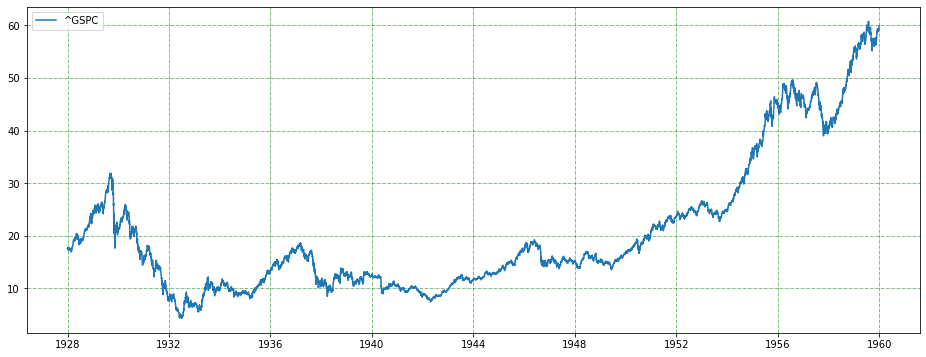

In [34]:
plot_stock_price('^GSPC', start_date='1900-01-01', end_date='1960-01-01')

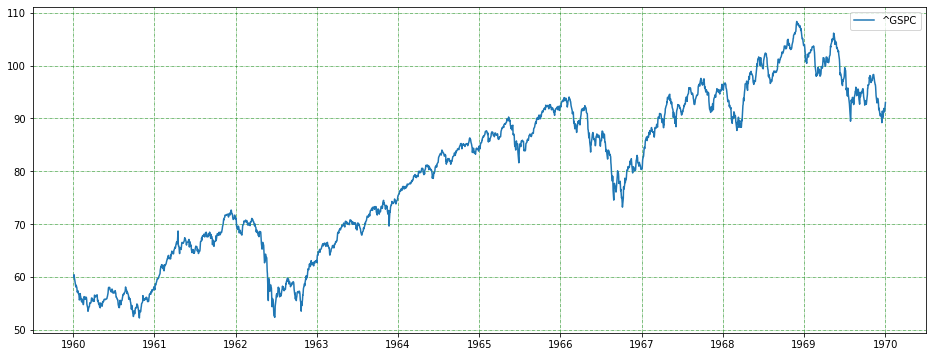

In [35]:
plot_stock_price('^GSPC', start_date='1960-01-01', end_date='1970-01-01')

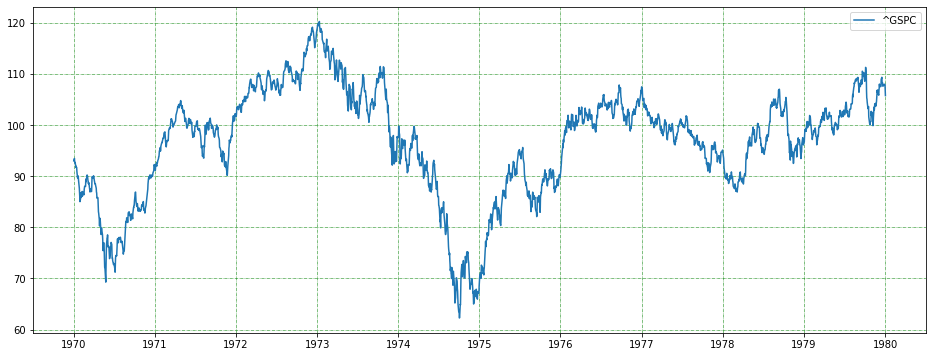

In [36]:
plot_stock_price('^GSPC', start_date='1970-01-01', end_date='1980-01-01')

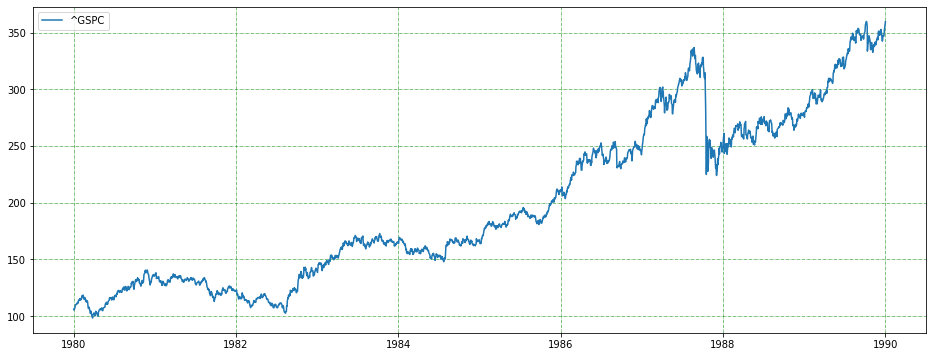

In [37]:
plot_stock_price('^GSPC', start_date='1980-01-01', end_date='1990-01-01')

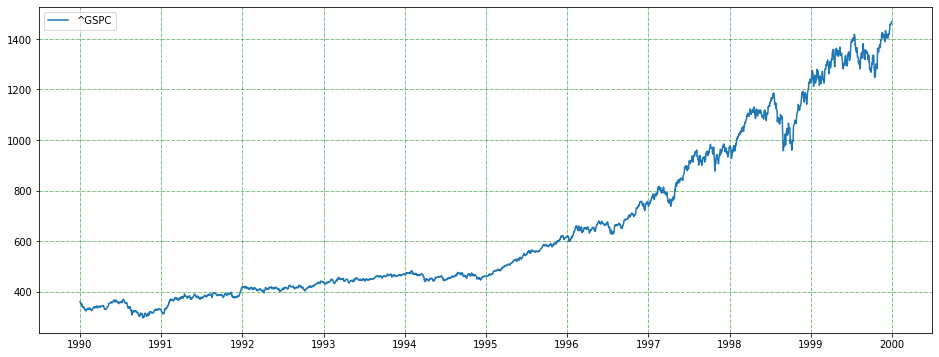

In [38]:
plot_stock_price('^GSPC', start_date='1990-01-01', end_date='2000-01-01')

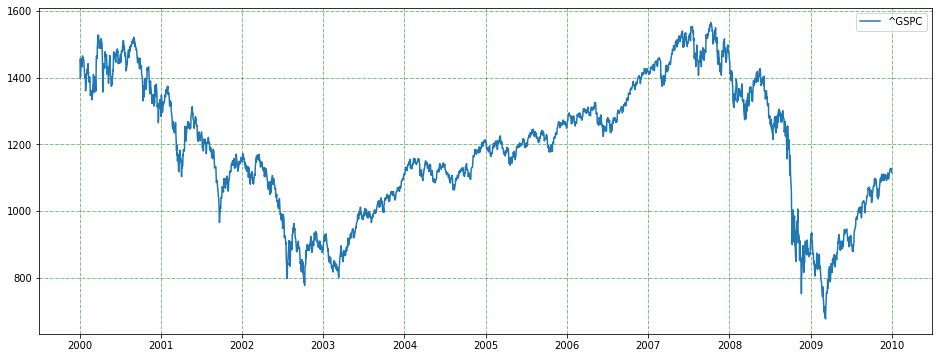

In [39]:
plot_stock_price('^GSPC', start_date='2000-01-01', end_date='2010-01-01')

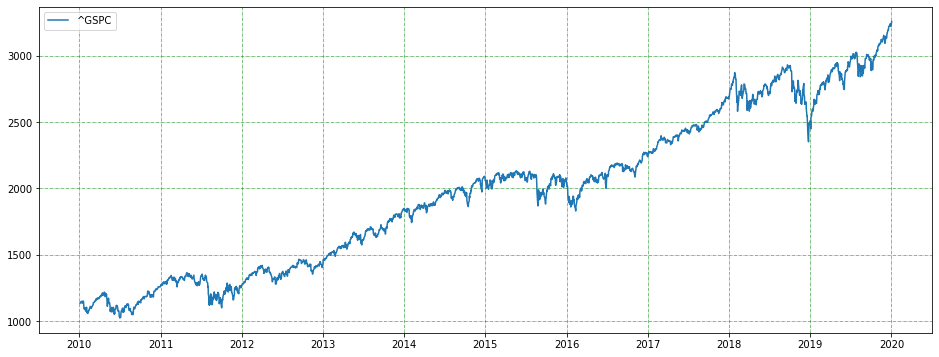

In [40]:
plot_stock_price('^GSPC', start_date='2010-01-01', end_date='2020-01-01')

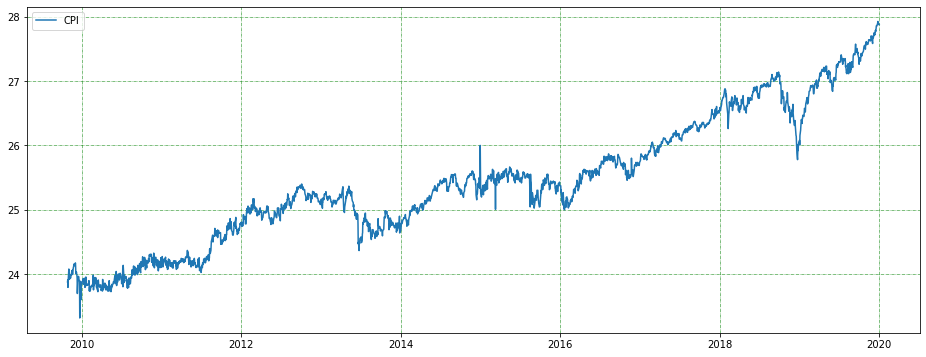

In [42]:
plot_stock_price('CPI', start_date='1990-01-01', end_date='2020-01-01')

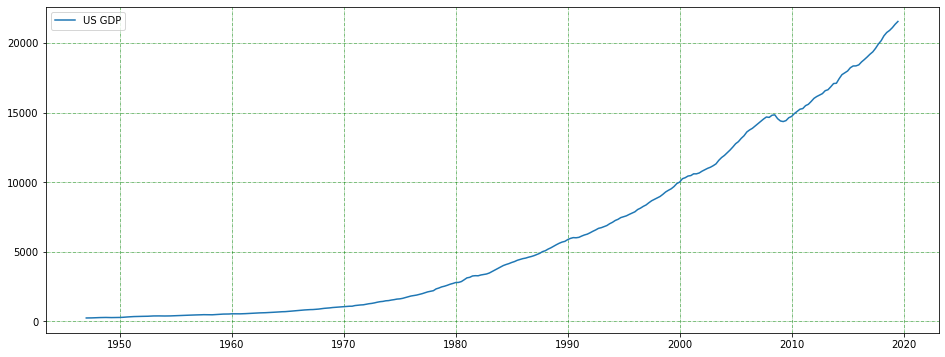

In [43]:
gdp = plot_us_gdp()

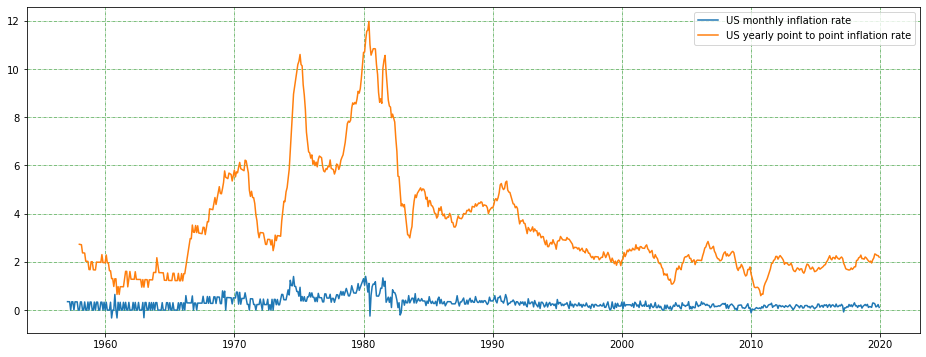

In [44]:
cpi_u_inflation_data = plot_us_inflation(index = 'CPILFESL')

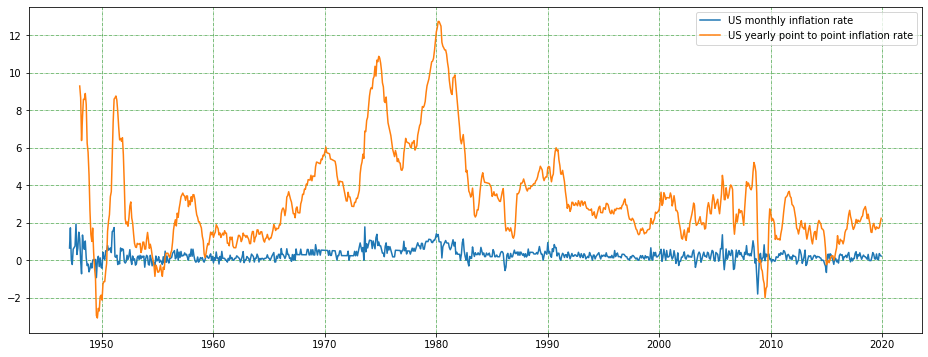

In [45]:
cpi_u_inflation_data = plot_us_inflation(index = 'CPIAUCSL')

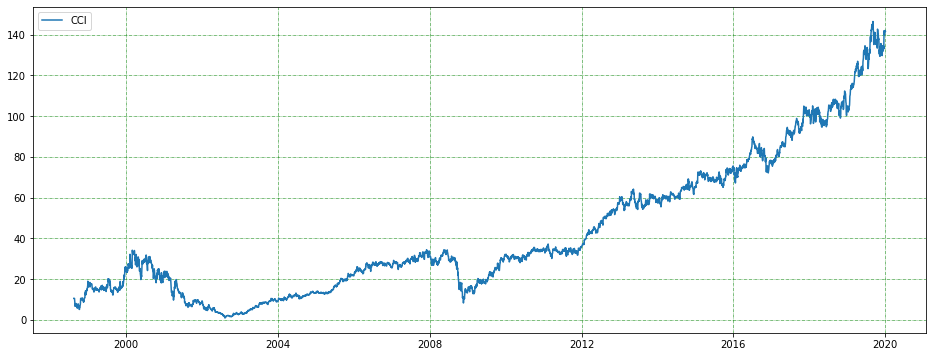

In [46]:
plot_stock_price('CCI', start_date='1960-01-01', end_date='2020-01-01')

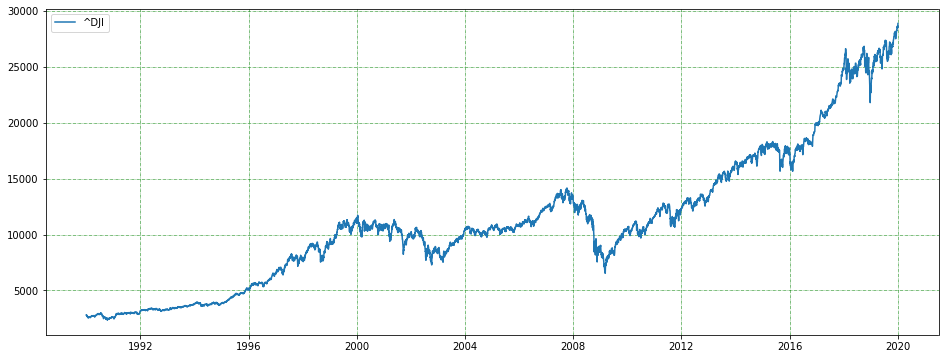

In [47]:
plot_stock_price('^DJI', start_date='1990-01-01', end_date='2020-01-01')

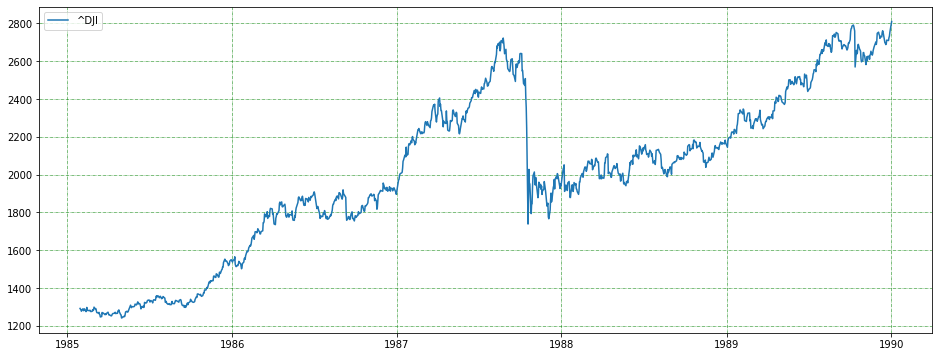

In [48]:
plot_stock_price('^DJI', start_date='1940-01-01', end_date='1990-01-01')

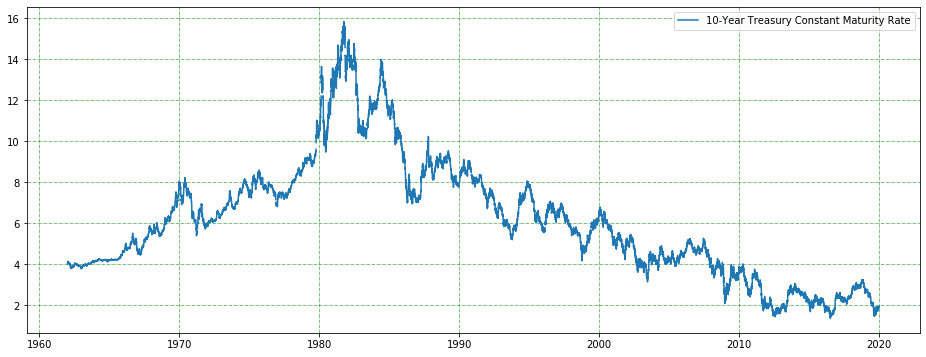

In [49]:
plot_index('DGS10', start_date = '1950-01-02')

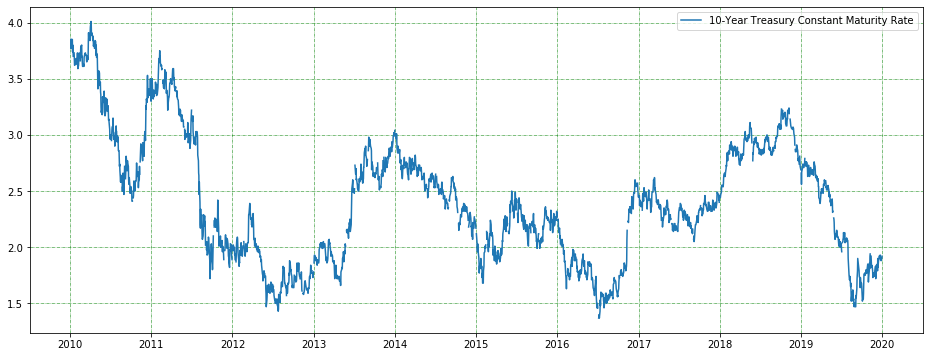

In [50]:
plot_index('DGS10', start_date = '2010-01-02')

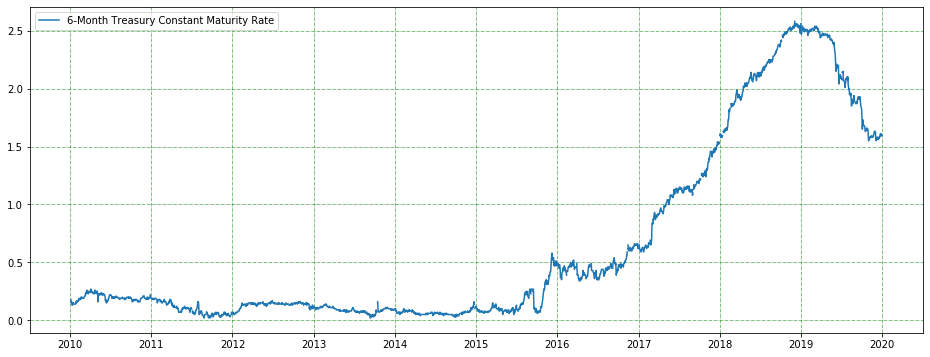

In [41]:
plot_index('DGS6MO')

In [ ]:
plot_index('FEDFUNDS')

In [ ]:
plot_index('UNRATE', start_date = '1910-01-02')

In [ ]:
plot_index('NIKKEI225')

In [ ]:
plot_index('GFDEGDQ188S', start_date = '1910-01-02')

In [ ]:
plot_index('GDPC1', start_date = '1910-01-02')

In [ ]:
plot_index('A191RL1Q225SBEA', start_date = '2010-01-02')

In [ ]:
plot_index('IRLTLT01JPM156N', start_date = '1940-01-02')

In [ ]:
nasdaq = data.get_nasdaq_symbols()
print(nasdaq.shape)
nasdaq.head()

In [ ]:
def compute_stats(symb):
    ticker = data.get_quote_yahoo(symb) 
    ticker['c1_marketCap_bn_calc'] = ticker['price'] * ticker['sharesOutstanding'] / 1e9
    ticker['c2_marketCap_bn_orig'] = ticker['marketCap'] / 1e9
    ticker['c3_price_calc'] = ticker['epsForward'] * ticker['trailingPE']
    ticker['c4_earnings_bn_calc'] = ticker['epsForward'] * ticker['sharesOutstanding'] / 1e9
    return ticker

In [ ]:
compute_stats(['EXPE', 'GOOG', 'MSFT', 'AAPL', 'BB', 'JNPR', 'BRK-B', 'BRK-A'])